# 光学画像の基礎分析2（雪質分析）
このnotebookでは、光学画像の基礎的な分析として、NDSIの類似手法による雪質の判定を取り扱います。

***注意:***
* **`~/examples` 内では上書き保存することができません。編集する場合は `~/work` ディレクトリへコピーしてから実行することをおすすめします。**
* **このnotebookで取得する全てのデータはTellus上での利用に限定されます**
* **このnotebookで利用するTellus APIには一部サンプル目的のものが含まれます。これは予告なく変更される場合がございます。**
* **このnotebookでの分析の正確性については一切保証いたしません**

In [30]:
import numpy as np
from skimage import io
from skimage import color
from skimage import img_as_ubyte
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

## NDSI（Normalized Difference Snow Index）とは
NDSIは雪を判定するために2つのバンド帯の差を取り、値を正規化したものです。
これは、雪の分光反射特性が波長 0.6㎛（緑）付近で高く、波長 1.5 ㎛（中間赤外）付近で低いことを利用しています。

緑波長（G）と中間赤外波長（SWIR）を用いて、

`NDSI = (G - SWIR) / (G + SWIR)` 

と計算されます。
閾値は `0.4` 周辺が一般に利用され、閾値以上の場合は積雪、閾値以下は非積雪と判定します。ですが、AVNIR-2の光学画像には、`Band1 (R)`, `Band2 (G)`, `Band3 (B)`, `Bnad4 (NIR)` の4band帯しかないため、SWIRを使わずに、NDSIに近いものを調査していきます。

似た指標として、以下のようなものがあります。

* NDVI: Normalized Difference Vegetation Index（正規化植生指数）
* NDWI: Normalized Difference Water Index（正規化水指数）

NDVIは植生の分布状況や活性度を示す指標で、近赤外波長（NIR）と赤波長（R）を用いて、 `NDVI = (NIR-R) / (NIR+R)` で計算されます。NDVIの値が大きくなるほど植生が濃いと判断されます。

NDWIは地表面における水の存在と深い関連をもつ指標の1つで、赤波長（R）と中間赤外波長（SWIR）を用いて、 `NDWI =(R-SWIR)/(R+SWIR)` で計算されます。NDWIの値が大きくなるほど表面が帯水状況にあると判断されます。

## Tellusからの光学画像の取得と前処理
富士山周辺の光学画像をTellusから取得します。今回はタイル化されたPNG形式のデータを扱います。位置の指定はXYZ方式を採用しています。詳細は [こちら（外部サイト）](https://maps.gsi.go.jp/development/siyou.html) をご覧ください。

詳細補足: ALOSという衛星のAVNIR-2と呼ばれるセンサから取得されたデータを扱います。AVNIR-2については [こちら（外部サイト）](https://www.eorc.jaxa.jp/ALOS/about/javnir2.htm) をご覧ください。

***注意:***
* **ここで利用しているAPIはサンプル目的のものです。Tellus Jupyter環境のみから利用できます。正式なAPIは今後追加される予定です。**

In [31]:
# APIのドメイン
URL_DOMAIN = "https://gisapi.opf-dev.jp/"

# 富士山の位置
Z = 13
X = 7252
Y = 3234

def get_data(img_type, domain=URL_DOMAIN, z=Z, x=X, y=Y):
    return io.imread("{}/{}/{}/{}/{}.png".format(domain, img_type, z, x, y))

img_osm = get_data("osm")
img_band1= get_data("av2ori/band1").astype('int32')
img_band2 = get_data("av2ori/band2").astype('int32')
img_band3 = get_data("av2ori/band3").astype('int32')
img_band4 = get_data("av2ori/band4").astype('int32')
img_true = np.c_[img_band3[:,:,0:1], img_band2[:,:,1:2], img_band1[:,:,2:3]]

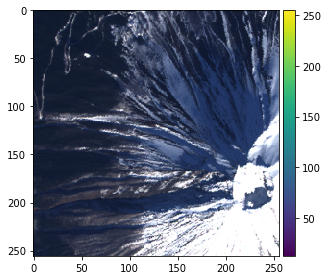

In [32]:
# 元画像確認
io.imshow(img_true)

## NDSIの代替を検証
`NDSI = (G - SWIR) / (G + SWIR)` を、`SWIR` の代わりに `NIR` を利用して検証していきます。

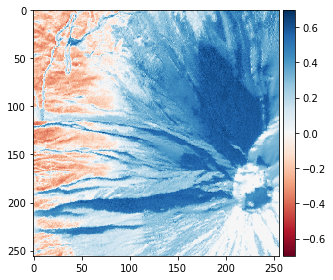

In [33]:
img_NDSI_24 = (img_band2[:,:,1] - img_band4[:,:,1])  / (img_band2[:,:,1] + img_band4[:,:,1])
io.imshow(img_NDSI_24)

Band4の代わりに、それぞれBand1, 3でも検証してみます。

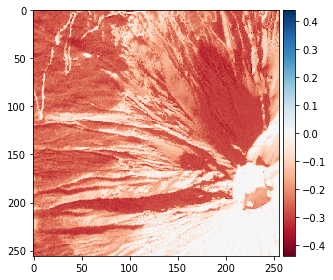

In [34]:
# Band4の代わりにBnad1を利用
img_NDSI_21 = (img_band2[:,:,1] - img_band1[:,:,2]) / (img_band2[:,:,1] + img_band1[:,:,2])
io.imshow(img_NDSI_21)

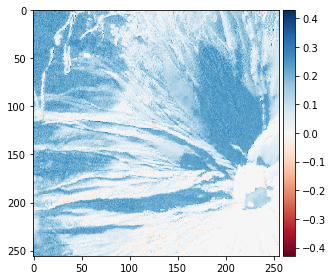

In [35]:
# Band4の代わりにBnad3を利用
img_NDSI_23 = (img_band2[:,:,1] - img_band3[:,:,0]) / (img_band2[:,:,1] + img_band3[:,:,0])
io.imshow(img_NDSI_23)

それ以外にも、Band4を固定した組み合わせも確認してみます。

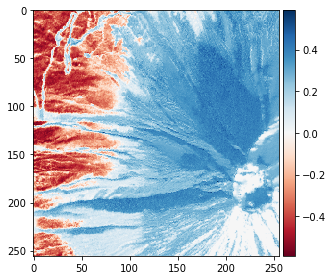

In [36]:
# Band3とBand4
img_NDSI_34 = (img_band3[:,:,0] - img_band4[:,:,0]) / (img_band3[:,:,0] + img_band4[:,:,0])
io.imshow(img_NDSI_34)

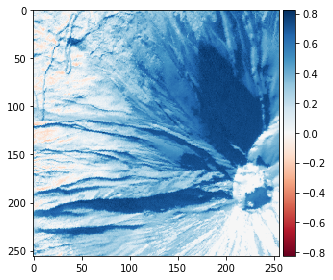

In [37]:
# Band1とBand4
img_NDSI_14 = (img_band1[:,:,2] - img_band4[:,:,0]) / (img_band1[:,:,2] + img_band4[:,:,0])

io.imshow(img_NDSI_14)

Band4を使うと近しい結果が得られたようです。Band2-Band4を利用し閾値の判定を行います。

## NDSIの閾値を調査
まずヒストグラムで分布を確認します。

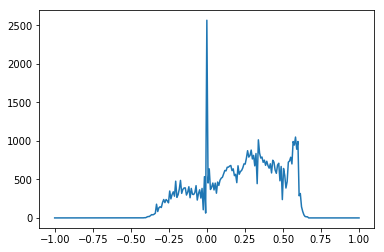

In [38]:
img_NDSI_24 =  (img_band2[:,:,1] - img_band4[:,:,1])  / (img_band2[:,:,1] + img_band4[:,:,1])
hists, bins=np.histogram(img_NDSI_24, 255, [-1, 1])
plt.plot(np.linspace(-1, 1, 255), hists)

2つのバンドの値が同じで、値が0になっているケースが多いことが分かります。

2つの山を分けるように、`0.2` を閾値にして分類してみます。

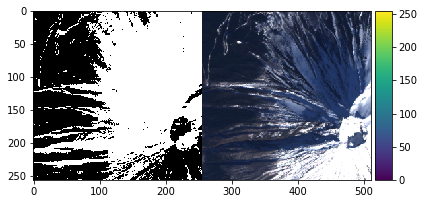

In [39]:
height, width= img_NDSI_24.shape
img_binary_24 = np.zeros((height, width)) # 0で初期化
img_binary_24 = img_NDSI_24 > 0.2 # 閾値にもとづいて2値化
io.imshow(np.concatenate((color.gray2rgb(img_binary_24*255), img_true), axis=1))

確かに `SWIR` を使わないとあまりうまく抽出できないことがわかりました。

## Band2-Band4を連続的な雪質と仮定してみる
雪判定には明度に基づくものを適用し、それでマスクを取ります。

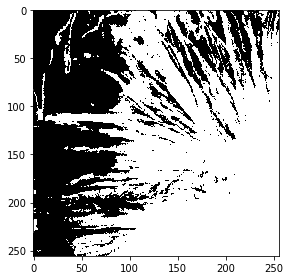

In [40]:
# RGB画像からHSV画像への変換
img_hsv = color.rgb2hsv(img_true.astype("uint8"))
img_v = img_hsv[:,:,2]

height, width= img_v.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_v > 90 / 255 # 閾値にもとづいて2値化

io.imshow(img_binary)

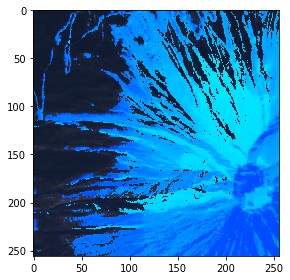

In [42]:
img_NDSI =  (img_band2[:,:,1] - img_band4[:,:,1]) / (img_band2[:,:,1] + img_band4[:,:,1])

# 明度を使って雪部分をマスキング
img_msk = img_true.copy()
img_msk[img_binary] = 0

# 雪部分にNDSIを使ってグラデーションをかける
# （薄い水色になるほど雪が深く、濃い青になるほど雪が薄い）
height, width= img_binary.shape
img_ndsi_grad = np.zeros((height, width, 3)) # 0で初期化
img_ndsi_grad[:,:,0] = 0
img_ndsi_grad[:,:,1] = (img_NDSI + 0.3 ) * 255 #値が0~255になるように修正
img_ndsi_grad[:,:,2] = 255
img_ndsi_grad[~img_binary] = 0

# 2つの画像を合成
img_ndsi_grad_msk  = img_ndsi_grad + img_msk

io.imshow(img_ndsi_grad_msk.astype("uint8"))

あくまで大雑把な仮定に基づく結果であることに注意してください。実際の雪質を表す教師データを組み合わせると、より確かな分析・検証が行うことができるでしょう。